<a href="https://colab.research.google.com/github/shabansatti/Global-Controller-for-Transient-Stability-and-Voltage-Regulation/blob/V2---Transient-Controller-through-Ricatti/Global_Controller___V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Modules
!pip install control
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pdb
import scipy
import control.matlab as mat
import pdb
from tabulate import tabulate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 8.2 MB/s eta 0:00:00


In [2]:
#@title Given Generator Parameters
sys_parameters={
    "H" : 4,
    "D" : 5,
    "Td0_t" : 6.9,
    "xL" : 0.4853,        # Line reactance
    "xd" : 1.863,         # Direct axis Synchronous Reactance
    "xd_t" : 0.657,       # Direct axis Transient Reactance
    "xT" : 0.127,         # Transformer Reactance
    "Kc" : 1             # Constant Kc
 }

In [3]:
#@title Given Initial Conditions
init_conditions = {
    "angle": 72*pi/180,        # Rotor Angle
    "Vt0" : 1.0,              # Terminal Voltage
    "Pm" : 0.90,           # Mechanical Power
    "w0" : 1,
    "del_Vt": 0
    }

In [4]:
#@title Disturbance Profile
# disturbance_profile=[disturbance time, line status/ratio, Mech. Power]
disturbance_profile_1 = np.array([[0.1, 0.035, 1], [0.25, 0, 1]]);
disturbance_profile_2 = np.array([[0.1, 0.035, 1], [0.25, 0, 1], [1, 1, 1.3]]);
disturbance_profile_3 = np.array([[0.1, 0.035, 1], [0.25, 0, 1], [1.4, 1, 1], [2.1, 0.035, 1], [2.25, 0, 1]]);

In [5]:
#@title SMIB Class
class SMIB:
  def __init__ (self,parameters,initial_conditions):
    self.pr=parameters;
    self.ic    = initial_conditions;
    self.xT    = self.pr["xT"];
    self.xL    = self.pr["xL"];
    self.xd_t  = self.pr["xd_t"]
    self.xd    = self.pr["xd"]
    self.D     = self.pr["D"]
    self.H     = self.pr["H"]
    self.Kc    = self.pr["Kc"]
    self.xs    = self.pr["xT"]+self.pr["xL"]/2;
    self.xds   = self.pr["xd"]+self.pr["xT"]+self.pr["xL"]/2;     # Pre_Fault Total Synchronous Reactance
    self.xds_t = self.pr["xd_t"]+self.pr["xT"]+self.pr["xL"]/2;   # Total Transient Reactance
    self.Td0_t = self.pr["Td0_t"];
    self.T_t   = self.xds_t*self.pr["Td0_t"]/self.xds;           # Transient Time Constant
    self.Pm    = self.ic["Pm"];
    self.Vt0    = self.ic["Vt0"];
    self.del_Vt= self.ic["del_Vt"];
    self.w0    = self.ic["w0"];
    self.init_angle = self.ic["angle"];
    self.Vt = self.Vt0;
    self.Vs = 0;

  def init_variables(self):
    Pe     = self.Pm;

    A = Pe * self.xs / sin (self.init_angle);
    B = self.xd_t * (cos (self.init_angle)) / self.xds_t;
    C = self.xd_t * (sin (self.init_angle)) / self.xds_t;
    A1 = -pow(B,2) - pow(C,2);
    B1 = pow(self.Vt,2) - 2*A*B;
    C1 = -pow(A,2)

    #a1=2 * self.xs * self.xd * Pe * self.xds/(
    #    sin(self.init_angle))-2*self.xs*self.xd*self.xds*Pe*(
    #        1/tan(self.init_angle))+pow((self.xds*self.Vt0),2);

    #a=sqrt(a1);
    #b=self.xd;
    #c=(sin(self.init_angle))/(self.xs*Pe*self.xds);

    #vs1=((a/b)+sqrt(pow((a/b),2)-(4/(b*c))))/2;
    #vs2=((a/b)-sqrt(pow((a/b),2)-(4/(b*c))))/2;
    Vs1 = (-B1 + sqrt(pow(B1,2)-(4*A1*C1))) / (2 * A1);
    Vs2 = (-B1 - sqrt(pow(B1,2)-(4*A1*C1))) / (2 * A1);
    if  (hypot(sqrt(Vs1),1)) < (hypot(sqrt(Vs2),1)):
      self.Vs = Vs1;
    else:
      self.Vs = Vs2;

    self.Vs = 1.3965;

    Eq_hat  = Pe * self.xds_t /(self.Vs * sin(self.init_angle));
    Id      = (Eq_hat - self.Vs * cos(self.init_angle)) / self.xds_t;
    Eq      = Eq_hat +  (self.xd - self.xd_t) * Id;
    Iq      = self.Vs * (sin (self.init_angle)) / self.xds_t;

    self.states=np.array([0., 0., Eq_hat])

    return self.states

In [6]:
#@title Child Class Dynamics
class Dynamics(SMIB):

  def __init__(self,parameters,initial_conditions,disturbance_profile=None, control_strategy=None, switching_time=None, alphas=None):

    super().__init__(parameters,initial_conditions);
    self.disturbance_profile = disturbance_profile;
    self.cont_strategy = control_strategy;
    self.cont_switch_time = switching_time;
    self.x = self.xds_t;
    self.alpha = alphas;
    self.line_status = None;
    self.controller_gain();


  def controller_gain (self):
    self.init_variables();
    At = np.array ([[0, 1, 0],[0, (-self.D/(2*self.H)), (-self.w0/(2*self.H))],[0, 0, (-1/self.Td0_t)]]);
    Bt = np.array ([[0], [0], [(1 / self.Td0_t)]]);
    Q  = np.array ([[500, 0,0], [0, 100, 0], [0, 0, 20]]);
    R  = np.array ([1 ]);

    self.Kt  = mat.care(At, Bt, Q, R=None)[2]
    temp_K   = np.array([[0]]);
    self.Kt  = (np.hstack((self.Kt, temp_K)));
    #print ("Kt: ", self.Kt)
    self.K   = self.Kt;

    angle_min = 10 * 3.14159 / 180 ;
    angle_max = 130 * 3.14159 / 180 ;
    Vt_min = 0.8;
    Vt_max = 1.1;
    Pe_min = 0.05;
    Pe_max = 1.2;
    f1 =  lambda angle, Vt, Pe: -(pow(Pe,2) * pow(self.xs,2) * cos(angle)) / (
        Vt * pow(self.Vs,2) * pow(sin(angle),3)) - (
            self.xs * self.xd_t * Pe) / (Vt * self.xds_t * pow((sin(angle)),2));

    f2 = lambda angle, Vt, Pe: (Pe * pow(self.xs,2)) / (Vt * pow(self.Vs,2) * pow(sin(angle),2)) + (
        self.xs * self.xd_t * cos(angle)) / (Vt * self.xds_t * (sin(angle)));

    f1max = f1 (angle_max, Vt_max, Pe_max)
    f1min = f1 (angle_min, Vt_min, Pe_min)

    f2max = f2 (angle_max, Vt_max, Pe_max)
    f2min = f2 (angle_min, Vt_min, Pe_min)

    f1_mean = 0.5 * (f1max + f1min);
    f2_mean = 0.5 * (f2max + f2min);


    #print ("f1max", f1max)
    #print ("f1min", f1min)

    #print ("f2max", f2max)
    #print ("f2min", f2min)

    Av = np.array ([[0, (-self.D / (2 * self.H)), (-self.w0 / (2 * self.H))], [0, 0, (-1 / self.Td0_t)], [0, f1_mean, (-f2_mean / self.Td0_t)]]);
    Bv = np.array ([0, (1 / self.Td0_t), (f2_mean / self.Td0_t)]);
    D = np.array([[0], [0], [1]]);
    E1 = np.array([f1max-f1_mean, 0, 0]);
    E2 = np.array([0, -(f2max-f2_mean)/self.Td0_t, 0]);
    F = (f2max-f2_mean)/self.Td0_t;
    lambda1 = 0.5;
    lambda2 = 0.5;
    epsilon = 2;
    A = Av - lambda2*Bv*(1/R)*F *E2.T;
    B1 = np.hstack ((sqrt(lambda1) * D, sqrt (epsilon * lambda2) * D))
    B2 = np.hstack (( sqrt (lambda2/epsilon) * Bv * (1/R) *F, sqrt(2/epsilon) * Bv));
    #print (sqrt (lambda2/epsilon) * Bv *(1/R)*F)
    #print (sqrt(2/epsilon) * Bv)
    #print ("Shape B1: ", np.shape(Bv))
    #print ("Shape B2: ", np.shape(B2))
    #B = np.hstack ((B1,B2));
    #print ("B", B)
    #print ("Shape B: ", np.shape(B))
    ##Q = Q + lambda1 * E1 * E1.T + lambda2 * epsilon * E2 * E2.T;
    #Kv  = mat.care(At, Bt, Q, R=None)[2]
    #self.Kv =np.array ([[0, 10.11, -30.81, -40.14]])

    self.Kv = np.array ([[0, -10.368686,     8.20120841,   0.22986416]])
    #P  = mat.care(At, Bt, Q, R=None)[0]
    #print ("Bv.T: ", Bv.T)
    #print ("P: ", P)
    #print ("X: ", X)
    #Kv = Bv.T * P * X.T;
    #self.Kv = mat.care(Av, Bv, Q, R=None)[2]
    self.K  = self.Kt;
    #print ("Kv: ", self.Kv)

  def star_delta(self, XA, XB, XC):

    X1 = ((XA*XB) + (XB*XC) + (XA*XC) )/ XB; # X1 is between terminals A & C
    X2 = ((XA*XB) + (XB*XC) + (XA*XC) )/ XC; # X2 is between terminals A & B
    X3 = ((XA*XB) + (XB*XC) + (XA*XC) )/ XA; # X3 is between terminals B & C

    return X1, X2, X3

  def controller_output (self, time):

    if (self.cont_strategy == "switching" and self.switch):

      self.K = self.Kv;

    elif(self.cont_strategy == "Global"):

      z  = sqrt(self.alpha[0] * pow(self.states[1],2) + self.alpha[1] * pow(self.del_Vt,2))
      mu = (1 - 1 / (1 + exp(-120*(z - 0.08)))) * (1 / (1 + exp(-120*(z + 0.08))));
      md = 1 - mu;
      self.K  = mu * self.Kv + md * self.Kt;


  def calculate_impedances (self):
    XA = 1;
    XB = 1;
    Y = 1;
    if (self.line_status is None):
      f = 0;
      self.xds_t = self.xd_t + self.xT + self.xL / 2;
      self.xds   = self.xd   + self.xT + self.xL / 2;
      x=self.xds_t;
      self.xs    = self.xT  + self.xL / 2;  # check again
      #print ("Pre-Fault Impedance: ", self.xds_t)
    elif not(self.line_status == 1 or self.line_status == 0):
      f = 1;
      [XA, x, XB] = self.star_delta (self.xd_t + self.xT, self.xL, self.line_status * self.xL);
      [YA, Y, YB] = self.star_delta (self.xT, self.xL, self.line_status * self.xL);

      #self.xds   = self.star_delta (self.xd + self.xT + self.xL, self.xL, self.line_status * self.xL);
      #print ("Fault Impedance: ", self.xds_t)
    else:
      f = 0;
      x = self.xd_t + self.xT + self.xL*(2-self.line_status)/2;
      #self.xds   = self.xd   + self.xT + self.xL*(2-self.line_status)/2;
      #self.xs    = self.xT  + self.xL*(2-self.line_status)/2;  # check again
      #print ("Post-Fault Impedance: ", self.xds_t)
    #print ("fault",f)
    return XA, x, XB, f, Y

  def check_disturbance (self, time):
    if not(self.disturbance_profile is None):
      temp=np.min(self.disturbance_profile[:,0])
      if (temp == time):
        temp_array = np.where(self.disturbance_profile[:,0] == temp);
        temp_index = temp_array[0][0];
        self.line_status= self.disturbance_profile[temp_index,1];

        self.Pm= self.disturbance_profile[temp_index,2] *self.Pm;
        if(np.shape(self.disturbance_profile)[0] == 1):
          self.disturbance_profile = None;
        elif (np.shape(self.disturbance_profile)[0] != 1):
          self.disturbance_profile = np.delete(self.disturbance_profile, temp_index, 0)


  def algebaric_equations(self, states, time):

    switch = lambda : True if (self.cont_switch_time and time >= self.cont_switch_time) else False;
    self.check_disturbance(time);
    X = self.calculate_impedances();
    #print (X)
    self.controller_output(switch);
    self.x = X[1];
    del_angle = states[0];
    del_w     = states[1];
    Eq_hat    = states[2];

    angle   = del_angle + self.init_angle;
    speed   = del_w + self.w0;
    Pe      = (Eq_hat * self.Vs * sin (angle)) / X[1];
    Id      = ((Eq_hat - self.Vs * cos(angle)) / X[1]) + (X[3] * ((Eq_hat) / X[0])) ;
    Vq      = Eq_hat - self.xd_t * Id;
    #Vq = ((X[3] * X [4] ) + (1 - X[3]) * (X[1] - self.xd_t)) * Id + self.Vs * cos (angle);

    #print (X[2])
    Iq      = self.Vs * (sin (angle)) / (X[1] + X[3] * (X[2] + self.xL));
    Vd      = self.xd_t * Iq;
    #Vd = -((X[3] * X [4] ) + (1 - X[3]) * (X[1] - self.xd_t)) * Iq + self.Vs * sin (angle);
    Eq      = Eq_hat +  (self.xd - self.xd_t) * Id;
    #Eq = 5.256559348901268;
    Q       = self.Vs * Id;
    self.Vt = sqrt (pow (Vd, 2) + pow(Vq,2));

    self.del_vt     = self.Vt - self.Vt0;

    vf      = np.matmul(-self.K, np.array([ del_angle, del_w, Pe-self.Pm, self.del_Vt]));
    vf = vf.flat[0]
    #print (np.shape(-self.K))
    #print (np.shape(vf))
    #print (np.shape(np.array([ del_angle, del_w, Pe-self.Pm, self.del_Vt])))
    #print ("states:", np.array([ del_angle, del_w, Pe-self.Pm, self.del_Vt]))
    #print ("vf: ", vf)
    #print ("Vf: ", vf)
    #Uf      = (1 / Iq) * (vf[0,0] - self.Td0_t * (Q + pow(self.Vs, 2) / X[1]) * del_w + self.Pm) + (self.xd - self.xd_t) * Id;
    Uf      = (1 / Iq) * (vf - self.Td0_t * (Eq_hat * self.Vs * (cos (angle)) / X[1]) * del_w + self.Pm) + (self.xd - self.xd_t) * Id;
    if (Uf>6):
      Uf = 6;
    elif (Uf<-6):
      Uf = -6
    Ef   = self.Kc * Uf
    #print ("time: ",time,"angle", angle, "speed", speed, "Q", Q,"reactance", self.x," Pe: ",Pe, " Id: ",Id," Iq: ",Iq," Eq_hat: ",Eq_hat," Eq: ",Eq," Vq: ",Vq," Vd: ",Vd, "Vt: ", self.Vt, "Uf: ", Uf)

    return Eq, Ef, Pe, del_w

  def differential_equations(self,curr_states,time):

    time = round(time,4);
    [Eq, Ef, Pe, del_w] = self.algebaric_equations(curr_states,time);
    states_der = [0,0,0];
    states_der[0]   = del_w;
    states_der[1]   = -(self.D/(2*self.H))*(del_w)-((self.w0)/(2*self.H))*(Pe-self.Pm)
    states_der[2]   = (Ef - Eq) / self.Td0_t;
    states_der = np.array([states_der[0], states_der[1], states_der[2]])
    #print ("States Der: ", states_der)
    return states_der

  def output_array(self,st_out,t):
    global states_stack, time_stack;
    angle   = st_out[0] + self.init_angle;
    speed   = st_out[1] + self.w0;
    Pe      = st_out[2] * self.Vs * (sin (angle)) / self.x;

    if (t == 0):
      states_stack = np.array ([angle, speed, Pe, self.Vt])
      time_stack = t;
    else:
      states_stack = np.vstack((states_stack,np.array ([angle, speed, Pe, self.Vt])));
      time_stack = np.vstack((time_stack,t));
    return states_stack, time_stack


In [7]:
def mod_euler_solver (model, step_size, sim_end_time):
  #pdb.set_trace();
  current_states = model.init_variables();
  no_of_iter = int((1/step_size)*sim_end_time);
  for i in range (1, no_of_iter, 1):
    model.output_array(current_states,(i-1)*step_size);
    sys_d           =   model.differential_equations(current_states,i*step_size );       # Der.Cal. using current last time step values
    sys_temp        =   current_states;
    #print ("Current_States: ", current_states)
    #print ("Sys_d: ", sys_d)
    current_states  +=  sys_d * step_size;                                  # Prediction Step
    sys_dp          =   model.differential_equations(current_states, i*step_size);       # Der. Cal. using Prediction
    current_states  =   sys_temp + (sys_dp + sys_d) * (step_size) / 2;      # Correction Step
    #print ("Current Out States: ", current_states)
  return model.output_array(current_states,sim_end_time);

In [8]:
#@title Function: Output Display
def display_output(states,time,plot_title):
  time=time;
  angle=states[:,0] * (180 / 3.14159);
  speed=states[:,1] * (314.159)
  elec_power=states[:,2]
  voltage=states[:,3]

  data = [['Rotor Angle', round(angle[0],4), round(angle[-1],4), round(angle[-1],4) - round(angle[0],4) ],
   ['Rotor Speed', round(speed[0],4), round(speed[-1],4), round(speed[-1],4) - round(speed[0],4)],
    ['Electrical Power',  round(elec_power[0],4), round(elec_power[-1],4), round(elec_power[-1],4) - round(elec_power[0],4)],
     ['Terminal Voltage',   round(voltage[0],4), round(voltage[-1],4), round(voltage[-1],4) - round(voltage[0],4)]];
  print (tabulate(data, headers=["Variable", "Initial Values", "Final Value", "Difference"]))
  plt.subplot(4,1,1)
  plt.plot(time, angle)
  plt.xlabel("Time")
  plt.ylabel("Rotor Angle")
  plt.title("Rotor Angle Graph ("+plot_title+" )")
  plt.show()

  plt.subplot(4,1,2)
  plt.xlabel("Time")
  plt.ylabel("Rotor Speed")
  plt.title("Rotor Speed Graph")
  plt.plot(time, speed)
  plt.show()
  plt.subplot(4,1,3)
  plt.xlabel("Time")
  plt.ylabel("Electrical Power")
  plt.title("Electrical Power Graph")
  plt.plot(time, elec_power)
  plt.show()
  plt.subplot(4,1,4)
  plt.xlabel("Time")
  plt.ylabel("Voltage")
  plt.title("Voltage Graph")
  plt.plot(time, voltage)
  plt.show()

Variable            Initial Values    Final Value    Difference
----------------  ----------------  -------------  ------------
Rotor Angle                72.0001        72.0001        0
Rotor Speed               314.159        314.159         0
Electrical Power            0.9            0.9           0
Terminal Voltage            1              0.9999       -0.0001


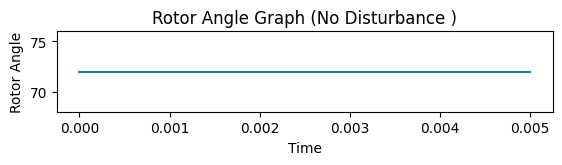

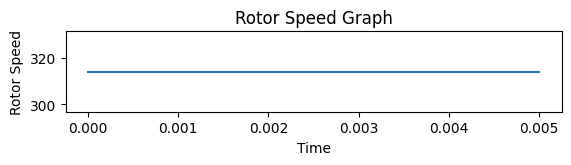

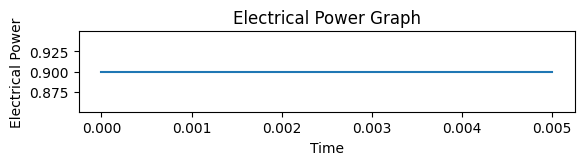

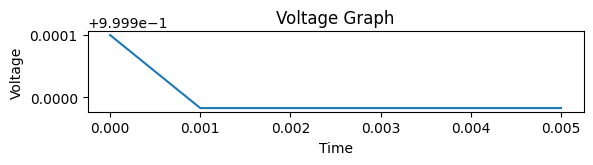

In [9]:
#@title No Fault Simulation
step_size = 0.001;
sim_end_time = 0.005;
kwargs={"parameters": sys_parameters,"initial_conditions": init_conditions};
model = Dynamics(**kwargs);
[states, time] = mod_euler_solver (model, step_size, sim_end_time);
display_output(states,time,"No Disturbance")

Variable            Initial Values    Final Value    Difference
----------------  ----------------  -------------  ------------
Rotor Angle                72.0001        71.9486       -0.0515
Rotor Speed               314.159        314.227         0.0679
Electrical Power            0.9            0.8973       -0.0027
Terminal Voltage            1              0.9376       -0.0624


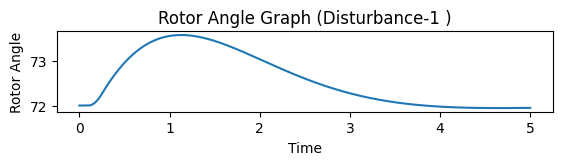

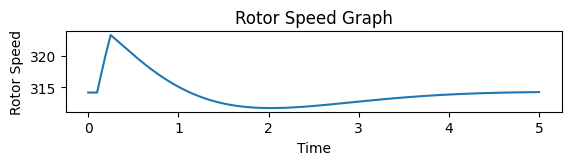

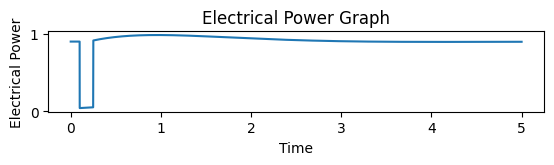

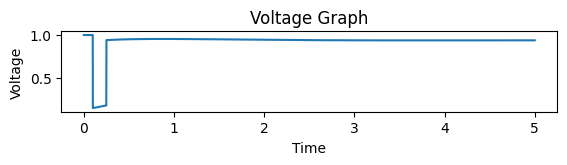

In [10]:
#@title  Fault-1 Simulation
step_size = .001;
sim_end_time = 5;
# , "control_strategy": "Global", "alphas" : [0.5,0.5]
kwargs={"parameters": sys_parameters,"initial_conditions": init_conditions,
        "disturbance_profile": disturbance_profile_1};
model_f1 = Dynamics(**kwargs);
[states, time] = (mod_euler_solver (model_f1, step_size, sim_end_time));
display_output(states,time,"Disturbance-1")

Variable            Initial Values    Final Value    Difference
----------------  ----------------  -------------  ------------
Rotor Angle                72.0001        71.9919       -0.0082
Rotor Speed               314.159        314.197         0.0383
Electrical Power            0.9            0.8998       -0.0002
Terminal Voltage            1              0.9381       -0.0619


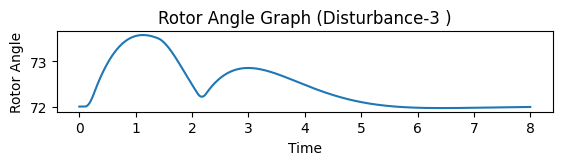

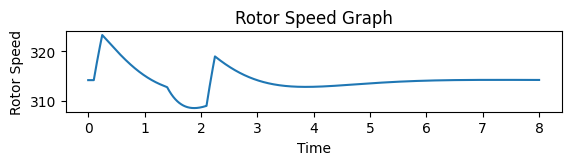

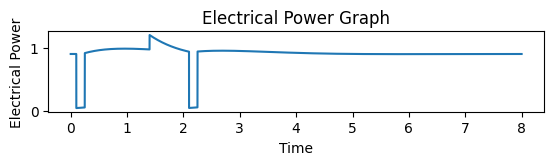

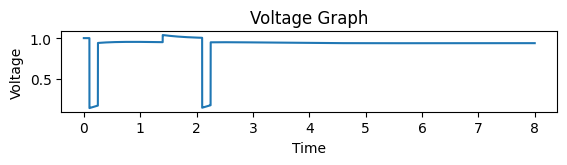

In [11]:
#@title  Fault-3 Simulation
step_size = 0.001;
sim_end_time = 8;
# , "control_strategy": "Global", "alphas" : [0.5,0.5]
kwargs={"parameters": sys_parameters,"initial_conditions": init_conditions, "disturbance_profile": disturbance_profile_3};
model_f3 = Dynamics(**kwargs);
[states, time] = (mod_euler_solver (model_f3, step_size, sim_end_time));
display_output(states,time,"Disturbance-3")

Variable            Initial Values    Final Value    Difference
----------------  ----------------  -------------  ------------
Rotor Angle                72.0001        72            -0.0001
Rotor Speed               314.159        314.159         0.0001
Electrical Power            0.9            1.17          0.27
Terminal Voltage            1              1.0414        0.0414


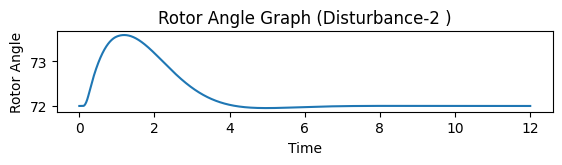

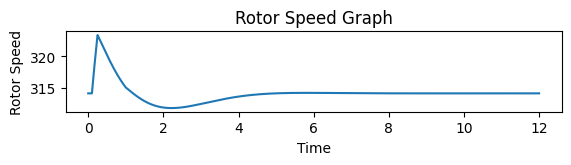

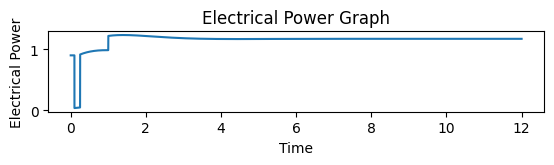

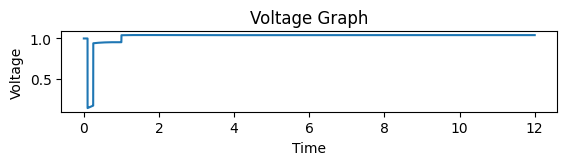

In [12]:
#@title  Fault-2 Simulation
step_size = 0.001;
sim_end_time = 12;
#"control_strategy": "Global", "alphas" : [0.5,0.5]
kwargs={"parameters": sys_parameters,"initial_conditions": init_conditions, "disturbance_profile": disturbance_profile_2};
model_f2 = Dynamics(**kwargs);
[states, time] = (mod_euler_solver (model_f2, step_size, sim_end_time));
display_output(states,time,"Disturbance-2")